In [1]:
import os
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import time
import warnings
import zipfile
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv1D,LSTM,Dense,Bidirectional,GRU,Lambda,Dropout
from tensorflow.keras.models import Sequential
import csv
%matplotlib inline

In [2]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset/sunspots.zip', 'r')
zip_ref.extractall('dataset')
zip_ref.close()

In [3]:
df = pd.read_csv('/content/dataset/Sunspots.csv')

In [4]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [5]:
df.isnull().sum()

Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

In [6]:
time_step = []
temps = []

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
with open('/content/dataset/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1
series = np.array(temps)
time = np.array(time_step)

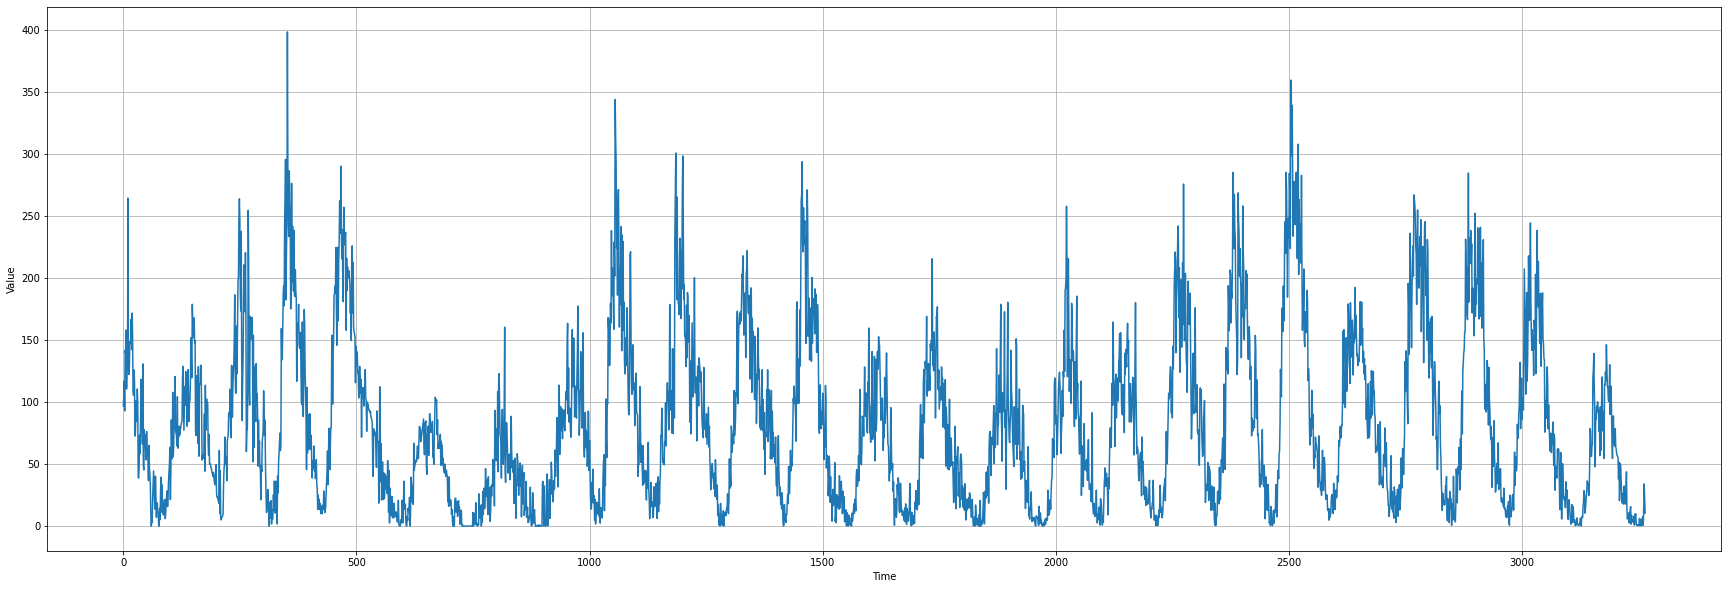

In [9]:
plt.figure(figsize=(30,10))
plot_series(time, series)

In [10]:
split_time = 2500
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
print(len(time_step))
print(len(temps))

3265
3265


In [12]:
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:] 

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [14]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)


In [35]:
model = tf.keras.models.Sequential([
                                    Conv1D(filters=60, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
                                    LSTM(60, return_sequences=True),
                                    LSTM(60, return_sequences=True),
                                    Dense(30, activation="relu"),
                                    Dense(10, activation="relu"),
                                    Dense(1),
                                    Lambda(lambda x: x * 400)
                                  ])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 60)          360       
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense_3 (Dense)              (None, None, 30)          1830      
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_5 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)          

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
25/25 [==============================] - 4s 36ms/step - loss: 64.2057 - mae: 64.7031
Epoch 2/100
25/25 [==============================] - 1s 35ms/step - loss: 59.9415 - mae: 60.4394
Epoch 3/100
25/25 [==============================] - 1s 35ms/step - loss: 56.1744 - mae: 56.6725
Epoch 4/100
25/25 [==============================] - 1s 35ms/step - loss: 53.3845 - mae: 53.8828
Epoch 5/100
25/25 [==============================] - 1s 35ms/step - loss: 51.2721 - mae: 51.7701
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 49.7059 - mae: 50.2040
Epoch 7/100
25/25 [==============================] - 1s 35ms/step - loss: 48.5134 - mae: 49.0113
Epoch 8/100
25/25 [==============================] - 1s 34ms/step - loss: 47.5386 - mae: 48.0367
Epoch 9/100
25/25 [==============================] - 1s 35ms/step - loss: 46.6535 - mae: 47.1509
Epoch 10/100
25/25 [==============================] - 1s 35ms/step - loss: 45.8271 - mae: 46.3244
Epoch 11/100
25/25 [=========

(1e-08, 0.0001, 0.0, 60.0)

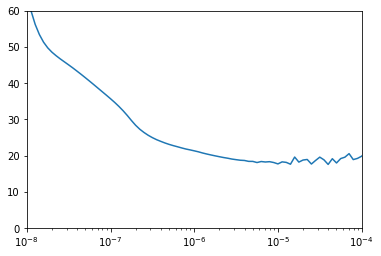

In [38]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

In [40]:
model = tf.keras.models.Sequential([
                                    Conv1D(filters=60, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
                                    LSTM(60, return_sequences=True),
                                    LSTM(60, return_sequences=True),
                                    Dense(30, activation="relu"),
                                    Dense(10, activation="relu"),
                                    Dense(1),
                                    Lambda(lambda x: x * 400)
                                  ])


In [41]:
optimizer = tf.keras.optimizers.SGD(learning_rate=5*1e-6, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=250)

Epoch 1/250
25/25 [==============================] - 5s 34ms/step - loss: 41.6290 - mae: 42.1258
Epoch 2/250
25/25 [==============================] - 1s 34ms/step - loss: 27.8529 - mae: 28.3475
Epoch 3/250
25/25 [==============================] - 1s 35ms/step - loss: 24.2241 - mae: 24.7186
Epoch 4/250
25/25 [==============================] - 1s 34ms/step - loss: 22.0152 - mae: 22.5091
Epoch 5/250
25/25 [==============================] - 1s 35ms/step - loss: 20.5918 - mae: 21.0852
Epoch 6/250
25/25 [==============================] - 1s 35ms/step - loss: 19.8974 - mae: 20.3907
Epoch 7/250
25/25 [==============================] - 1s 35ms/step - loss: 19.3497 - mae: 19.8426
Epoch 8/250
25/25 [==============================] - 1s 35ms/step - loss: 19.0005 - mae: 19.4934
Epoch 9/250
25/25 [==============================] - 1s 36ms/step - loss: 18.6825 - mae: 19.1746
Epoch 10/250
25/25 [==============================] - 1s 35ms/step - loss: 18.9234 - mae: 19.4158
Epoch 11/250
25/25 [=========

In [47]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

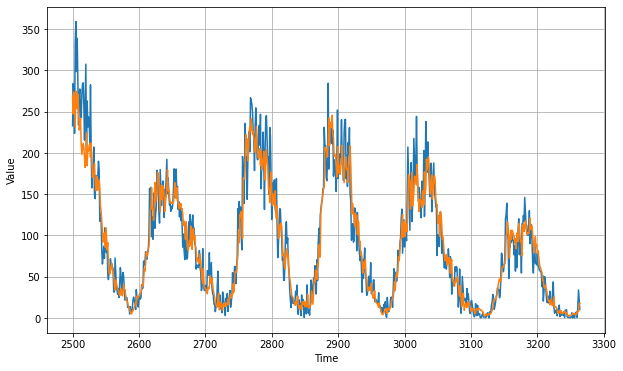

In [48]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [49]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.860153

In [50]:
print(rnn_forecast)

[268.59943   247.2897    273.7375    251.72787   231.41055   274.9762
 273.98578   253.47586   271.08698   253.1999    227.75612   232.88887
 241.70966   210.52928   198.18498   204.85048   211.24582   207.46436
 193.68604   182.35695   197.34286   224.38283   184.57706   205.01189
 202.50809   209.09958   210.6611    194.87122   212.0934    193.23103
 170.40494   173.94423   175.61507   186.98691   168.30121   154.20819
 160.7915    171.51772   154.7066    161.21463   167.36682   157.71873
 136.33151   129.51335   116.62121   103.5954     92.021      94.9778
 103.02738    85.73867   109.36811   101.78023    82.8606     91.25384
  65.03633    53.7513     52.745193   56.479645   62.087715   65.78005
  59.019745   56.857456   50.33088    40.099216   33.97964    46.20617
  42.82719    38.000504   35.148003   33.237045   30.615639   27.008856
  31.331093   35.372845   30.573803   26.802605   31.313175   40.35096
  34.304066   34.45818    26.322487   21.383072   20.691494   18.724333
  13.9

In [52]:
model.save("sunspots.h5")